### Imports

In [1]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from ntk import NTK
import matplotlib.pyplot as plt 
import numpy as np

### Funcs

#### NTK Class

In [2]:
class NTK(Kernel):
    def __init__(self, 
        depth, 
        c = 2.0,
        bias = 0.1,
        bias_bounds = (1e-5, 1e5)
    ):
        self.depth = depth
        self.c = c
        self.bias = bias
        self.bias_bounds = bias_bounds

    @property
    def hyperparameter_bias(self):
        return Hyperparameter("bias", "numeric", self.bias_bounds)

    # Need's rewrite -> 2007.01580 uses x,z in R^d not whole matricies
    # sigma_0(X,Z) = X @ Z.T -> usually vector x vector = scaler
    #                        -> but with n x m     
    def __call__(self, X, Z=None, eval_gradient=False):
        aug = False
        X_shape = -1
        Z_shape = -1
        products = [] # only used for gradient evaluation

        if eval_gradient:
            products.append(1.0) # placeholder, sigma info starts at index 1

        if Z is None:
            Z = X
        else:
            X_shape = X.shape[0]
            Z_shape = Z.shape[0]
            A = np.concatenate((X, Z), axis=0)
            X = A 
            Z = A
            aug = True
            
        Σ_mat = X @ Z.T
        K = Σ_mat + self.bias**2
        
        for dep in range(1, self.depth + 1):
            diag = np.diag(Σ_mat) + 1e-10
            denominator = np.sqrt(np.outer(diag, diag))
            λ = np.clip(Σ_mat / denominator, a_min=-1, a_max=1)
            Σ_mat = (self.c / (2 * np.pi)) * (λ * (np.pi - np.arccos(λ)) + np.sqrt(1 - λ**2)) * denominator
            Σ_mat_dot = (self.c / (2 * np.pi)) * (np.pi - np.arccos(λ))
            K = K * Σ_mat_dot + Σ_mat + self.bias**2

            if eval_gradient:
                products.append(products[-1] * Σ_mat)
            
        if eval_gradient:
            if not self.hyperparameter_bias.fixed:
                K_gradient = 2 * self.bias**2 * products[-1] * sum(1/products)
                K_gradient = np.expand_dims(K, -1)
                return K, K_gradient
            else:
                return K, np.empty((X.shape[0], X.shape[0], 0))
        else:
            if aug:
                return (1/self.depth) * K[0:X_shape, X_shape:(X_shape + Z_shape)]
            else:
                return (1/self.depth) * K
        
    def diag(self, X):
        return np.einsum("ij,ij->i", X, X)

    def is_stationary(self):
        """Returns whether the kernel is stationary."""
        return False

    def __repr__(self):
        return "{0}(depth={1:d}, c={2:.3f}, bias={3:.3f})".format(
                self.__class__.__name__, self.depth, self.c, self.bias)

#### NTK Function

In [3]:
"""
Neural Tangent Kernel Precompute
https://github.com/LeoYu/neural-tangent-kernel-UCI/
"""
def ntk_value(X, d_max, fix_dep): 
    K = np.zeros((d_max, X.shape[0], X.shape[0]))
    Σ_mat = np.matmul(X, X.T)
    Σ_mat_dot = np.zeros_like(Σ_mat)
    for dep in range(d_max):
        if fix_dep <= dep:
            Σ_mat_dot += Σ_mat
        K[dep] = Σ_mat_dot
        L = np.diag(Σ_mat)
        P = np.clip(np.sqrt(np.outer(L, L)), a_min = 1e-9, a_max = None)
        λ = np.clip(Σ_mat / P, a_min = -1, a_max = 1)
        Σ_mat = (λ * (math.pi - np.arccos(λ)) + np.sqrt(1.0 - λ * λ)) * P / 2.0 / math.pi
        Σ_mat_dot = Σ_mat_dot * (math.pi - np.arccos(λ)) / 2.0 / math.pi
    return K[d_max - 1]

#### Correlation

In [2]:
def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

## 2D Function

### Dataset

In [8]:
z = np.linspace(-2, 2, 100)
x = (z**2 + 1) * np.sin(np.linspace(-np.pi, np.pi, 100))
y = (z**2 + 1) * np.cos(np.linspace(-np.pi, np.pi, 100))

X = np.stack((x, y), axis=1)
z = z.reshape((-1, 1))

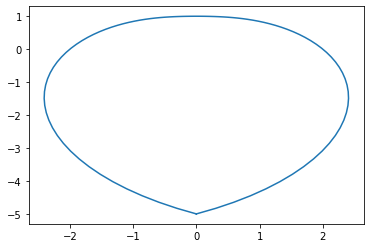

In [9]:
plt.plot(x,y)

In [10]:
X_train, X_test, z_train, z_test = train_test_split(
    X, z, test_size=0.5, random_state=624562)

### Gaussian Process - Noiseless

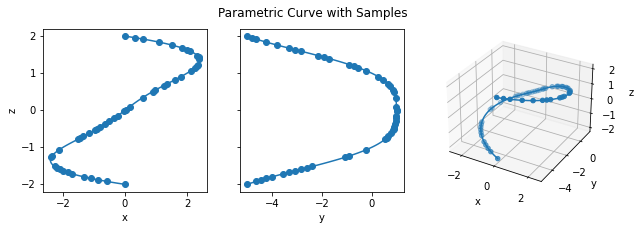

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharey=True ,figsize=(10, 3), gridspec_kw={'width_ratios' : [1, 1, 1]})
ax3.remove()
ax3 = fig.add_subplot(1,3,3, projection='3d')

ax1.plot(X[:,0], z)
ax1.scatter(X_train[:,0], z_train)
ax1.set_xlabel('x')
ax1.set_ylabel('z')
ax2.plot(X[:,1], z)
ax2.scatter(X_train[:,1], z_train)
ax2.set_xlabel('y')
ax3.plot(X[:,0], X[:,1], z.ravel())
ax3.scatter(X_train[:,0], X_train[:,1], z_train)
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('z')
_ = fig.suptitle("Parametric Curve with Samples")

In [12]:
X_train_norm = normalize(X_train)
z_train_norm = normalize(z_train)

X_norm = normalize(X)
z_norm = normalize(z)

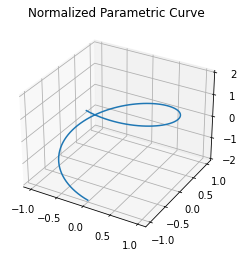

In [13]:
fig = plt.figure(); ax = fig.add_subplot(projection='3d')
ax.plot(X_norm[:,0], X_norm[:,1], z.ravel())
_=ax.set_title("Normalized Parametric Curve")

In [27]:
neural_tangent_kernel = (
    ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-9, 1e5)) * 
    NTK(depth=2, c=2, bias=1e-9, 
        bias_bounds=(1e-9, 1e2)) #+ 
    # WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-9, 1e5))
)
gp_ntk = GPR(kernel=neural_tangent_kernel, alpha=1e-5, n_restarts_optimizer=100)
gp_ntk.fit(X_train_norm, z_train_norm)

laplace_kernel = (
    ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-9, 1e10)) * 
    Matern(length_scale=100,
        length_scale_bounds=(1e-9, 1e3), 
        nu=1/2) #+
    # WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-9, 1e5))
)
gp_lpk = GPR(kernel=laplace_kernel, alpha=1e-5, n_restarts_optimizer=9)
gp_lpk.fit(X_train_norm, z_train_norm)

print('NTK     : ', gp_ntk.kernel_)
print('Laplace : ', gp_lpk.kernel_)

/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


NTK     :  302**2 * NTK(depth=2, c=2.000, bias=99.293)
Laplace :  404**2 * Matern(length_scale=1e-09, nu=0.5)


/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-09. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [28]:
mean_ntk = gp_ntk.predict(X_norm)
mean_lpk = gp_lpk.predict(X_norm)

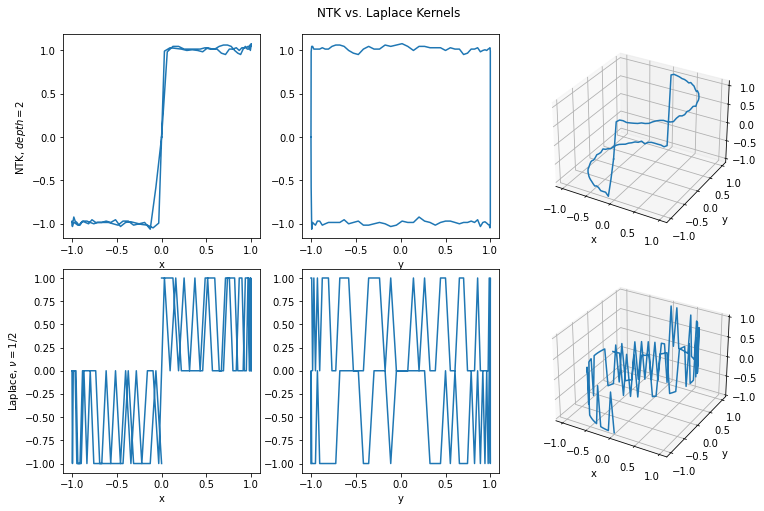

In [29]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharey=False, figsize=(10, 7), gridspec_kw={'width_ratios' : [1, 1, 1]})
ax = ax.ravel()
ax[2].remove()
ax[2] = fig.add_subplot(2,3,3, projection='3d')
ax[5].remove()
ax[5] = fig.add_subplot(2,3,6, projection='3d')
fig.tight_layout()
fig.subplots_adjust(top=.925)

ax[0].plot(X_norm[:,0], mean_ntk.ravel())
ax[0].set_xlabel('x')
ax[0].set_ylabel(r'NTK, $depth=2$')
ax[1].plot(X_norm[:,1], mean_ntk.ravel())
ax[1].set_xlabel('y')
ax[2].plot(X_norm[:,0], X_norm[:,1], mean_ntk.ravel())
ax[2].set_xlabel('x')
ax[2].set_ylabel('y')

ax[3].plot(X_norm[:,0], mean_lpk.ravel())
ax[3].set_xlabel('x')
ax[3].set_ylabel(r'Laplace, $\nu = 1/2$')
ax[4].plot(X_norm[:,1], mean_lpk.ravel())
ax[4].set_xlabel('y')
ax[5].plot(X_norm[:,0], X_norm[:,1], mean_lpk.ravel())
ax[5].set_xlabel('x')
ax[5].set_ylabel('y')

_=fig.suptitle("NTK vs. Laplace Kernels")

### Gaussian Process - Noisy

In [30]:
X_train_noisy = np.random.normal(X_train, scale=0.15)
z_train_noisy = np.random.normal(z_train, scale=0.15)

X_noisy = np.random.normal(X, scale=0.15)
# X_noisy = X

In [31]:
X_train_noisy_norm = normalize(X_train_noisy)
z_train_noisy_norm = normalize(z_train_noisy)

X_noisy_norm = normalize(X_noisy)

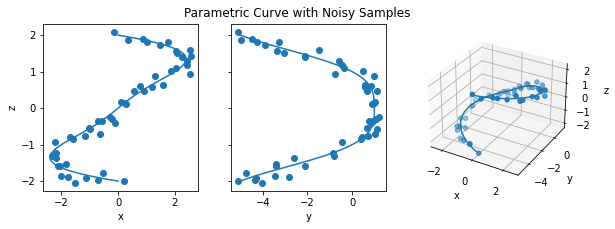

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharey=True ,figsize=(8, 3), gridspec_kw={'width_ratios' : [1, 1, 1]})
ax3.remove()
ax3 = fig.add_subplot(1,3,3, projection='3d')
fig.tight_layout()
fig.subplots_adjust(top=.9)

ax1.plot(X[:,0], z)
ax1.scatter(X_train_noisy[:,0], z_train_noisy)
ax1.set_xlabel('x')
ax1.set_ylabel('z')
ax2.plot(X[:,1], z)
ax2.scatter(X_train_noisy[:,1], z_train_noisy)
ax2.set_xlabel('y')
ax3.plot(X[:,0], X[:,1], z.ravel())
ax3.scatter(X_train_noisy[:,0], X_train_noisy[:,1], z_train_noisy)
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('z')
_ = fig.suptitle("Parametric Curve with Noisy Samples")

In [33]:
neural_tangent_kernel = (
    ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-9, 1e5)) * 
    NTK(depth=2, c=2, bias=1e-9, bias_bounds=(1e-9, 1e2)) + 
    WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-9, 1e5))
)
gp_ntk_noisy = GPR(kernel=neural_tangent_kernel, alpha=1e-6, n_restarts_optimizer=9)
gp_ntk_noisy.fit(X_train_noisy_norm, z_train_noisy_norm)

laplace_kernel = (
    ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-9, 1e10)) * 
    Matern(length_scale_bounds=(2e-10, 1e5), nu=1/2) +
    WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-9, 1e5))
)
gp_lpk_noisy = GPR(kernel=laplace_kernel, alpha=1e-6, n_restarts_optimizer=9)
gp_lpk_noisy.fit(X_train_noisy_norm, z_train_noisy_norm)

print('NTK     : ', gp_ntk_noisy.kernel_, '\nLaplace : ', gp_lpk_noisy.kernel_)

/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


NTK     :  0.492**2 * NTK(depth=2, c=2.000, bias=0.702) + WhiteKernel(noise_level=0.108) 
Laplace :  1.16**2 * Matern(length_scale=2.91, nu=0.5) + WhiteKernel(noise_level=0.102)


In [34]:
# Predict on noisy dataset
mean_ntk_noisy = gp_ntk_noisy.predict(X_noisy_norm)
mean_lpk_noisy = gp_lpk_noisy.predict(X_noisy_norm)

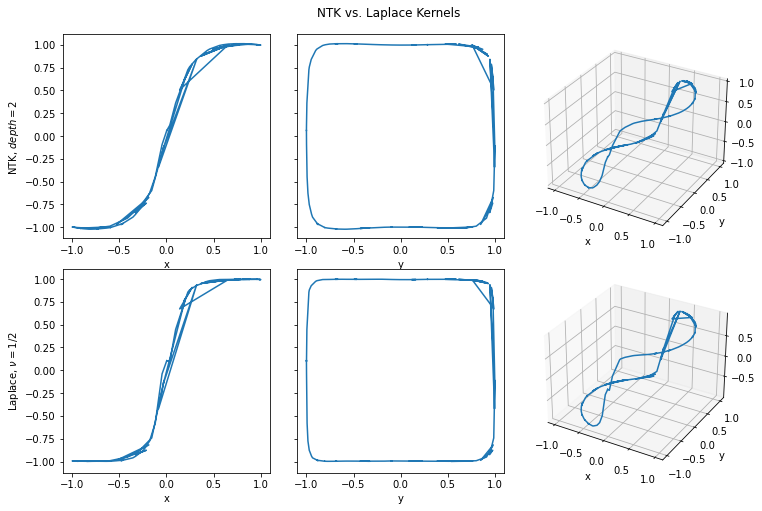

In [35]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharey=True ,figsize=(10, 7), gridspec_kw={'width_ratios' : [1, 1, 1]})
ax = ax.ravel()
ax[2].remove()
ax[2] = fig.add_subplot(2,3,3, projection='3d')
ax[5].remove()
ax[5] = fig.add_subplot(2,3,6, projection='3d')
fig.tight_layout()
fig.subplots_adjust(top=.925)

ax[0].plot(X_noisy_norm[:,0], mean_ntk_noisy.ravel())
ax[0].set_xlabel('x')
ax[0].set_ylabel(r'NTK, $depth=2$')
ax[1].plot(X_noisy_norm[:,1], mean_ntk_noisy.ravel())
ax[1].set_xlabel('y')
ax[2].plot(X_noisy_norm[:,0], X_noisy_norm[:,1], mean_ntk_noisy.ravel())
ax[2].set_xlabel('x')
ax[2].set_ylabel('y')

ax[3].plot(X_noisy_norm[:,0], mean_lpk_noisy.ravel())
ax[3].set_xlabel('x')
ax[3].set_ylabel(r'Laplace, $\nu = 1/2$')
ax[4].plot(X_noisy_norm[:,1], mean_lpk_noisy.ravel())
ax[4].set_xlabel('y')
ax[5].plot(X_noisy_norm[:,0], X_noisy_norm[:,1], mean_lpk_noisy.ravel())
ax[5].set_xlabel('x')
ax[5].set_ylabel('y')

_=fig.suptitle("NTK vs. Laplace Kernels")

### Sample Paths

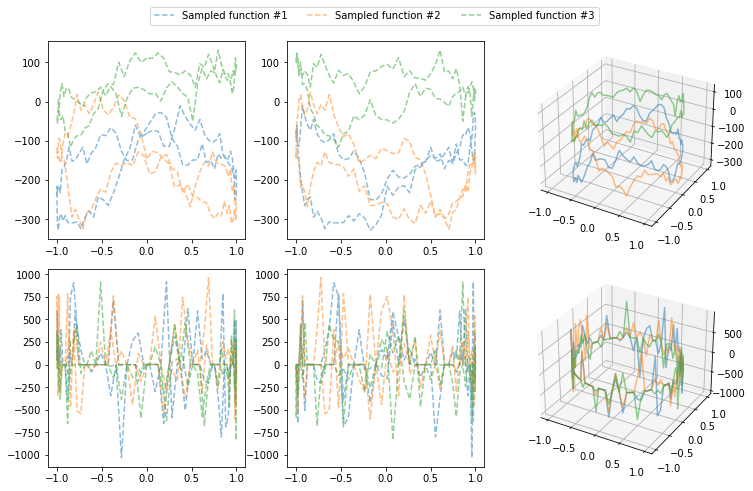

In [37]:
neural_tangent_kernel = (
    ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-9, 1e2)) * 
    NTK(depth=3, c=2, bias=100, bias_bounds='fixed') #+ 
    # WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-9, 1e5))
)

laplace_kernel = (
    ConstantKernel(constant_value=1e-2, constant_value_bounds=(1e-9, 1e2)) * 
    Matern(length_scale=1, 
        length_scale_bounds='fixed',#(2e-10, 1e5), 
        nu=1/2) #+
    # WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-9, 1e5))
)

gp_ntk_sample = GPR(kernel=neural_tangent_kernel)
mean_ntk_sample = gp_ntk_sample.predict(X_norm)
samples_ntk = gp_ntk_sample.sample_y(X_norm, 3)

gp_lpk_sample = GPR(kernel=laplace_kernel)
mean_lpk_sample = gp_lpk_sample.predict(X_norm)
samples_lpk = gp_lpk.sample_y(X_norm, 3)
samples_lpk = np.squeeze(samples_lpk)


fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10,7))
ax = ax.ravel()
ax[2].remove()
ax[2] = fig.add_subplot(2,3,3, projection='3d')
ax[5].remove()
ax[5] = fig.add_subplot(2,3,6, projection='3d')
fig.tight_layout()
fig.subplots_adjust(top=.9)

for i, prior in enumerate(samples_ntk.T):
    ax[0].plot(X_norm[:,0], prior, linestyle="--", alpha=0.5, label=f"Sampled function #{i + 1}")
    ax[1].plot(X_norm[:,1], prior, linestyle="--", alpha=0.5)
    ax[2].plot(X_norm[:,0], X_norm[:,1], prior, alpha=0.5)

for i, prior in enumerate(samples_lpk.T):
    ax[3].plot(X_norm[:,0], prior, linestyle="--", alpha=0.5)
    ax[4].plot(X_norm[:,1], prior, linestyle="--", alpha=0.5)
    ax[5].plot(X_norm[:,0], X_norm[:,1], prior, alpha=0.5)

fig.legend(bbox_to_anchor=(0, .85, 1, 0.2), loc='center', ncol=3)

In [ ]:
# do posterior-sample paths -> include constant kernel for scaling 

In [56]:
X_3d = np.mgrid[0:10, 0:10]/10
X_3d -= .5
X_3d = X_3d.reshape(-1, 2)

In [57]:
X_3d.shape

(100, 2)

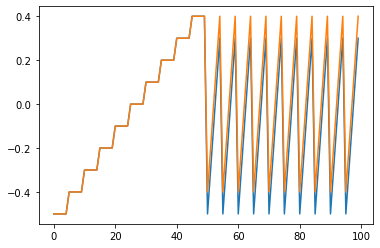

In [58]:
plt.plot(X_3d)

In [59]:
neural_tangent_kernel = (
    ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-9, 1e2)) * 
    NTK(depth=3, c=2) #+ 
    # WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-9, 1e5))
)

laplace_kernel = (
    ConstantKernel(constant_value=1e-2, constant_value_bounds=(1e-9, 1e2)) * 
    Matern(length_scale=1, length_scale_bounds=(2e-10, 1e5), nu=1/2) #+
    # WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-9, 1e5))
)

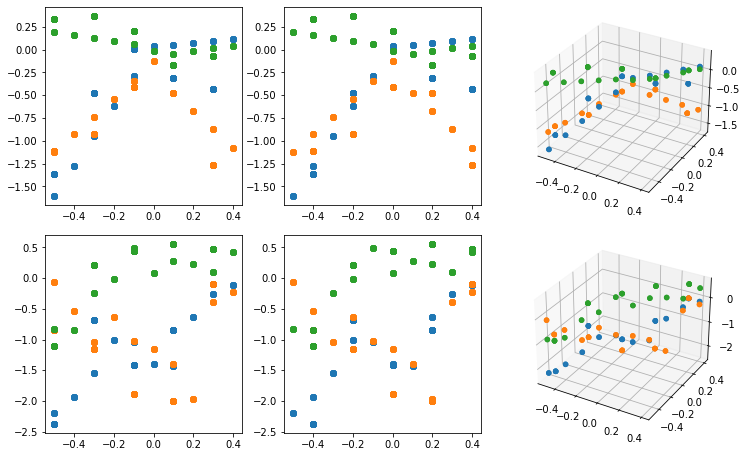

In [60]:
gp_ntk_sample = GPR(kernel=neural_tangent_kernel)
mean_ntk_sample = gp_ntk_sample.predict(X_3d)
samples_ntk = gp_ntk_sample.sample_y(X_3d, 3)

gp_lpk_sample = GPR(kernel=laplace_kernel)
mean_lpk_sample = gp_lpk_sample.predict(X_3d)
samples_lpk = gp_lpk.sample_y(X_3d, 3)
samples_lpk = np.squeeze(samples_lpk)


fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10,7))
ax = ax.ravel()
ax[2].remove()
ax[2] = fig.add_subplot(2,3,3, projection='3d')
ax[5].remove()
ax[5] = fig.add_subplot(2,3,6, projection='3d')
fig.tight_layout()
fig.subplots_adjust(top=.9)

for i, prior in enumerate(samples_ntk.T):
    ax[0].plot(X_3d[:,0], prior)#, linestyle="--", alpha=0.5, label=f"Sampled function #{i + 1}")
    ax[1].plot(X_3d[:,1], prior)#, linestyle="--", alpha=0.5)
    ax[2].plot(X_3d[:,0], X_3d[:,1], prior, alpha=0.5)

for i, prior in enumerate(samples_lpk.T):
    ax[3].plot(X_3d[:,0], prior)#, linestyle="--", alpha=0.5)
    ax[4].plot(X_3d[:,1], prior)#, linestyle="--", alpha=0.5)
    ax[5].plot(X_3d[:,0], X_3d[:,1], prior, alpha=0.5)

# fig.legend(bbox_to_anchor=(0, .85, 1, 0.2), loc='center', ncol=3)

## 1D Function

### Dataset

In [3]:
x_2d = np.linspace(0, 2*np.pi).reshape(-1, 1)
x_2d -= 3
y_2d = np.sin(x_2d)

In [4]:
x_2d_train, x_2d_test, y_2d_train, y_2d_test = train_test_split(
    x_2d, y_2d, test_size=0.5, random_state=624562)

x_2d_train_noisy = x_2d_train
y_2d_train_noisy = np.random.normal(y_2d_train, scale=0.05)

### Gaussian Process Noiseless

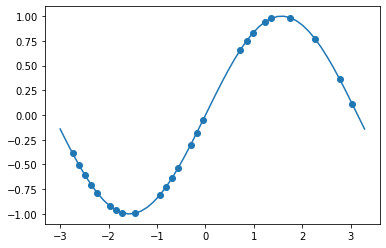

In [11]:
fig, ax = plt.subplots()
ax.plot(x_2d, y_2d)
ax.scatter(x_2d_train, y_2d_train)

In [12]:
np.random.seed(1923048)

neural_tangent_kernel = (
    ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-9, 1e5)) * 
    NTK(depth=2, c=2, bias=1e-9, bias_bounds='fixed') #+ 
    #WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-9, 1e5))
)
gp_ntk_2d = GPR(kernel=neural_tangent_kernel, alpha=1e-6, n_restarts_optimizer=9)
gp_ntk_2d.fit(x_2d_train, y_2d_train)

laplace_kernel = (
    ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-9, 1e10)) * 
    Matern(length_scale=0.01, length_scale_bounds='fixed', 
    nu=1/2) #+
    #WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-9, 1e5))
)
gp_lpk_2d = GPR(kernel=laplace_kernel, alpha=1e-6, n_restarts_optimizer=9)
gp_lpk_2d.fit(x_2d_train, y_2d_train)

print('NTK     : ', gp_ntk_2d.kernel_, '\nLaplace : ', gp_lpk_2d.kernel_)

NTK     :  40**2 * NTK(depth=2, c=2.000, bias=0.000) 
Laplace :  0.718**2 * Matern(length_scale=0.01, nu=0.5)


In [13]:
mean_ntk_2d = gp_ntk_2d.predict(x_2d)
mean_lpk_2d = gp_lpk_2d.predict(x_2d)

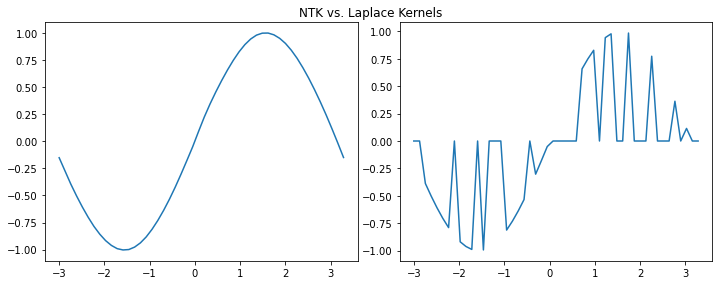

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), gridspec_kw={'width_ratios' : [1, 1]})
ax = ax.ravel()
fig.tight_layout()
fig.subplots_adjust(top=.925)

ax[0].plot(x_2d, mean_ntk_2d.ravel())
ax[1].plot(x_2d, mean_lpk_2d.ravel())

_=fig.suptitle("NTK vs. Laplace Kernels")

In [20]:
t = np.linspace(-8, 8, 100)
t = t.reshape(-1,1)
t.shape

(100, 1)

/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:478: RuntimeWarning: covariance is not positive-semidefinite.
  rng.multivariate_normal(y_mean[:, i], y_cov, n_samples).T[:, np.newaxis]


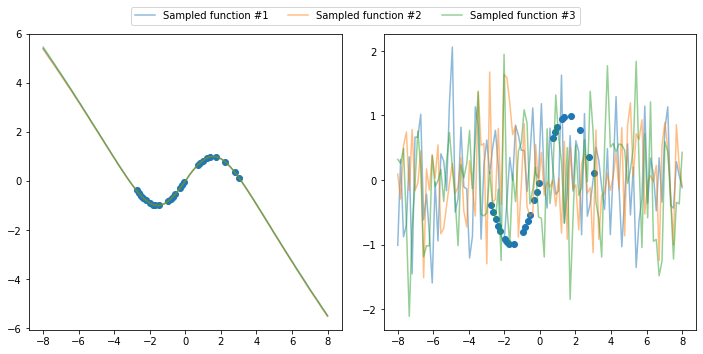

In [16]:
n_samples = 3

mean_ntk_sample = gp_ntk_2d.predict(t)
samples_ntk = gp_ntk_2d.sample_y(t, n_samples, random_state=np.random.randint(1000000000))
samples_ntk = np.squeeze(samples_ntk)

mean_lpk_sample = gp_lpk_2d.predict(t)
samples_lpk = gp_lpk_2d.sample_y(t, n_samples, random_state=np.random.randint(1000000000))
samples_lpk = np.squeeze(samples_lpk)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax = ax.ravel()
fig.tight_layout()
fig.subplots_adjust(top=.9)

for i, prior in enumerate(samples_ntk.T):
    ax[0].plot(t, prior, alpha=0.5, label=f"Sampled function #{i + 1}")

for i, prior in enumerate(samples_lpk.T):
    ax[1].plot(t, prior, alpha=0.5)

# ax[0].plot(t, samples_ntk, linestyle="--", alpha=0.5, label="Sampled function")
# ax[1].plot(t, samples_lpk, linestyle="--", alpha=0.5)

ax[0].scatter(x_2d_train, y_2d_train)
ax[1].scatter(x_2d_train, y_2d_train)

# ax[0].set_ylim(-4, 1.2)
# ax[1].set_ylim(-1.2, 1.2)

fig.legend(bbox_to_anchor=(0, .85, 1, 0.2), loc='center', ncol=3)

In [ ]:
# in thesis include plots like this ^ for depth = 1,2,3,4,5 and with lengthscales for c (invert with 1/c)

### Gaussian Process Noisy

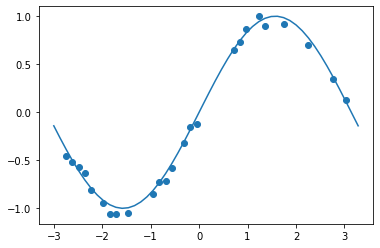

In [23]:
fig, ax = plt.subplots()
ax.plot(x_2d, y_2d)
ax.scatter(x_2d_train_noisy, y_2d_train_noisy)

In [24]:
neural_tangent_kernel = (
    ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-9, 1e2)) * 
    NTK(depth=2, c=2, bias=.1, bias_bounds='fixed') + #(1e-9, 1e2)) + 
    WhiteKernel(noise_level=1e-9, noise_level_bounds='fixed')#(1e-9, 1e2))
)
gp_ntk_2d = GPR(kernel=neural_tangent_kernel, alpha=1e-6, n_restarts_optimizer=9)
gp_ntk_2d.fit(x_2d_train_noisy, y_2d_train_noisy)

laplace_kernel = (
    ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-9, 1e2)) * 
    Matern(length_scale=2, length_scale_bounds='fixed',#(2e-10, 1e5), 
        nu=1/2) +
    WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-9, 1e2))
)
gp_lpk_2d = GPR(kernel=laplace_kernel, alpha=1e-6, n_restarts_optimizer=9)
gp_lpk_2d.fit(x_2d_train_noisy, y_2d_train_noisy)

print('NTK     : ', gp_ntk_2d.kernel_)
print('Laplace : ', gp_lpk_2d.kernel_)

/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


NTK     :  10**2 * NTK(depth=2, c=2.000, bias=0.100) + WhiteKernel(noise_level=1e-09)
Laplace :  0.394**2 * Matern(length_scale=2, nu=0.5) + WhiteKernel(noise_level=1e-09)


/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-09. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [25]:
# prior covariance matrix 
cov_ntk = gp_ntk_2d.kernel_(x_2d_train_noisy)[15:19, 15:19] 
cov_lpk = gp_lpk_2d.kernel_(x_2d_train_noisy)[15:19, 15:19]

# correlation_from_covariance(cov_ntk), correlation_from_covariance(cov_lpk)
cov_ntk, cov_lpk

(array([[1152.65935364,   31.25542727,  104.75238232,   65.17710535],
        [  31.25542727,   73.30651961,  246.30981831,  153.15421819],
        [ 104.75238232,  246.30981831,  836.13051838,  518.53480042],
        [  65.17710535,  153.15421819,  518.53480042,  321.7914517 ]]),
 array([[0.15519507, 0.02748392, 0.01194267, 0.01870735],
        [0.02748392, 0.15519507, 0.06743736, 0.10563588],
        [0.01194267, 0.06743736, 0.15519507, 0.09907567],
        [0.01870735, 0.10563588, 0.09907567, 0.15519507]]))

In [26]:
mean_ntk_2d, std_ntk = gp_ntk_2d.predict(x_2d, return_std=True)
mean_lpk_2d, std_lpk = gp_lpk_2d.predict(x_2d, return_std=True)

Hello


In [27]:
std_ntk, std_lpk

(array([0.00115722, 0.00088458, 0.00067038, 0.00052072, 0.00041507,
        0.00039583, 0.00039874, 0.00041311, 0.00044009, 0.00046008,
        0.00047853, 0.00050859, 0.00054158, 0.00057674, 0.00059642,
        0.00059581, 0.00056715, 0.00053155, 0.00053658, 0.0006221 ,
        0.0007356 , 0.00075944, 0.00086987, 0.00098675, 0.01111787,
        0.0071149 , 0.00446934, 0.00263997, 0.00146349, 0.00080533,
        0.00055113, 0.00051896, 0.00053195, 0.00053948, 0.00054588,
        0.00055881, 0.00058017, 0.00060795, 0.00062899, 0.00064739,
        0.00065248, 0.00064831, 0.00062223, 0.0005936 , 0.0005794 ,
        0.00060136, 0.00067799, 0.00082067, 0.00102744, 0.00128614]),
 array([0.1873704 , 0.13666825, 0.00100097, 0.00100095, 0.00100095,
        0.00100095, 0.00100096, 0.09968493, 0.00100096, 0.00100095,
        0.00100096, 0.09968493, 0.00100098, 0.12192183, 0.14068593,
        0.12192183, 0.00100097, 0.00100095, 0.00100095, 0.00100096,
        0.09968493, 0.00100096, 0.00100095, 0.

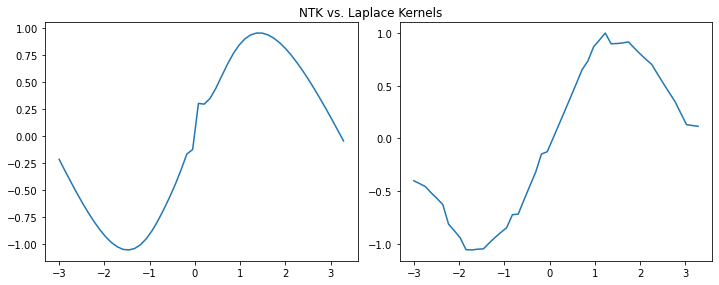

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), gridspec_kw={'width_ratios' : [1, 1]})
ax = ax.ravel()
fig.tight_layout()
fig.subplots_adjust(top=.925)

ax[0].plot(x_2d, mean_ntk_2d.ravel())
ax[1].plot(x_2d, mean_lpk_2d.ravel())

_=fig.suptitle("NTK vs. Laplace Kernels")

### Sample Paths

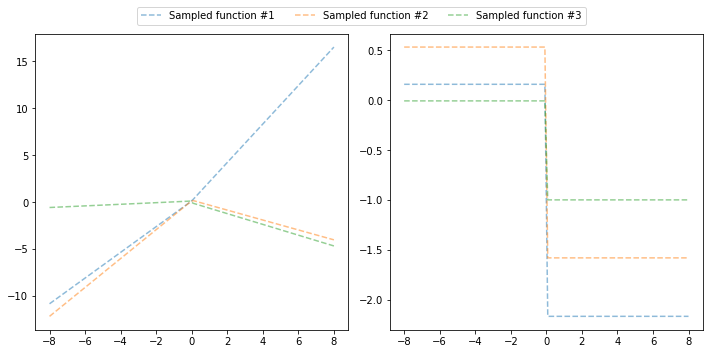

In [21]:
T = normalize(t)

n_samples = 3

neural_tangent_kernel = (
    ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-9, 1e5)) * 
    NTK(depth=2, c=2) #+ 
    # WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-9, 1e5))
)

gp_ntk_sample = GPR(kernel=neural_tangent_kernel)
mean_ntk_sample = gp_ntk_sample.predict(t.reshape(-1,1))
samples_ntk = gp_ntk_sample.sample_y(t.reshape(-1,1), n_samples, random_state=np.random.randint(1000000000))
samples_ntk = np.squeeze(samples_ntk)t = np.linspace(-10, 10, 100)

gp_lpk_sample = GPR(kernel=laplace_kernel)
mean_lpk_sample = gp_lpk_sample.predict(T)
samples_lpk = gp_lpk_sample.sample_y(np.stack((T,T), axis=1).squeeze(), n_samples, random_state=np.random.randint(1000000000))
samples_lpk = np.squeeze(samples_lpk)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax = ax.ravel()
fig.tight_layout()
fig.subplots_adjust(top=.9)

for i, prior in enumerate(samples_ntk.T):
    ax[0].plot(t, prior, linestyle="--", alpha=0.5, label=f"Sampled function #{i + 1}")

for i, prior in enumerate(samples_lpk.T):
    ax[1].plot(t, prior, linestyle="--", alpha=0.5)

# ax[0].plot(t, samples_ntk, linestyle="--", alpha=0.5, label="Sampled function")
# ax[1].plot(t, samples_lpk, linestyle="--", alpha=0.5)

fig.legend(bbox_to_anchor=(0, .85, 1, 0.2), loc='center', ncol=3)

/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:478: RuntimeWarning: covariance is not positive-semidefinite.
  rng.multivariate_normal(y_mean[:, i], y_cov, n_samples).T[:, np.newaxis]


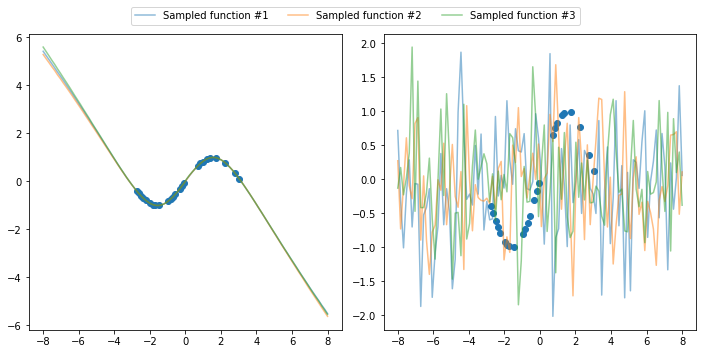

In [22]:
n_samples = 3

mean_ntk_sample = gp_ntk_2d.predict(t)
samples_ntk = gp_ntk_2d.sample_y(t, n_samples, random_state=np.random.randint(1000000000))
samples_ntk = np.squeeze(samples_ntk)

mean_lpk_sample = gp_lpk_2d.predict(t)
samples_lpk = gp_lpk_2d.sample_y(t, n_samples, random_state=np.random.randint(1000000000))
samples_lpk = np.squeeze(samples_lpk)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax = ax.ravel()
fig.tight_layout()
fig.subplots_adjust(top=.9)

for i, prior in enumerate(samples_ntk.T):
    ax[0].plot(t, prior, alpha=0.5, label=f"Sampled function #{i + 1}")

for i, prior in enumerate(samples_lpk.T):
    ax[1].plot(t, prior, alpha=0.5)

# ax[0].plot(t, samples_ntk, linestyle="--", alpha=0.5, label="Sampled function")
# ax[1].plot(t, samples_lpk, linestyle="--", alpha=0.5)

ax[0].scatter(x_2d_train, y_2d_train)
ax[1].scatter(x_2d_train, y_2d_train)

# ax[0].set_ylim(-4, 1.2)
# ax[1].set_ylim(-1.2, 1.2)

fig.legend(bbox_to_anchor=(0, .85, 1, 0.2), loc='center', ncol=3)

## 1. $-\sum^6_{k=1} k\sin((k+1)x + k)$

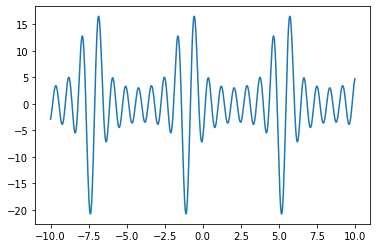

In [3]:
x = np.linspace(-10, 10, 1000).reshape(-1,1)
y = sum([k * np.sin((k+1)*x + k) for k in range(1, 7)])
plt.plot(x,y)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.5, random_state=624562)

x_train_noisy = np.random.normal(x_train, scale=0.15)
y_train_noisy = np.random.normal(y_train, scale=0.15)

In [5]:
np.random.seed(1923048)

neural_tangent_kernel = (
    ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-9, 1e5)) * 
    NTK(depth=2, c=2, bias=0.5, bias_bounds=(1e-5, 1e5)) #+ 
    #WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-9, 1e5))
)

gp_ntk_2d = GPR(kernel=neural_tangent_kernel, alpha=1e-6, n_restarts_optimizer=9)
gp_ntk_2d.fit(x_train, y_train)

laplace_kernel = (
    ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-9, 1e10)) * 
    Matern(length_scale=0.01, length_scale_bounds=(2e-10, 1e5), 
    nu=1/2) #+
    #WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-9, 1e5))
)
gp_lpk_2d = GPR(kernel=laplace_kernel, alpha=1e-6, n_restarts_optimizer=9)
gp_lpk_2d.fit(x_train, y_train)

print('Neural  : ', gp_ntk_2d.kernel_, '\nLaplace : ', gp_lpk_2d.kernel_)

mean_ntk = gp_ntk_2d.predict(x)
mean_lpk = gp_lpk_2d.predict(x)

/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Neural  :  2.25**2 * NTK(depth=2, c=2.000, bias=0.007) 
Laplace :  6.38**2 * Matern(length_scale=1.31, nu=0.5)


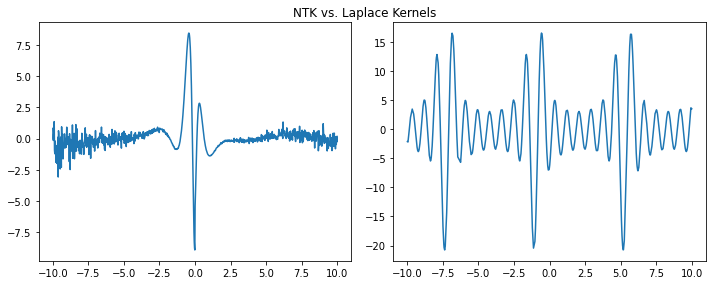

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), gridspec_kw={'width_ratios' : [1, 1]})
ax = ax.ravel()
fig.tight_layout()
fig.subplots_adjust(top=.925)

ax[0].plot(x, mean_ntk.ravel())
ax[1].plot(x, mean_lpk.ravel())

_=fig.suptitle("NTK vs. Laplace Kernels")